In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

class Therm_cond:
    def __init__(self, a, T0, T0_profile, Lx, Lt, dx, dt, method = 'A'):#T0_profile - начальный профиль температуры
            #dx, dt - размеры шагов
            # 'A' - аналитическое решение, 'E' - явная схема, 'NE' - неявная, 'EN' - явная с охлаждением Ньютона
        self.a = a
        self.T0_profile = T0_profile 
        self.Lx = Lx
        self.Lt = Lt
        self.dx = dx
        self.dt = dt
        self.Nx = int(Lx/dx + 1)
        self.Nt = int(Lt/dt + 1)
        #self.snapshots = snapshots
        self.method = method
        self.eta = a**2*dt/dx**2
        print 'eta = ', self.eta
        self.analytical_number_of_members = 100
        self.T0 = T0 #максимальное значение температуры. Понадобится для аналитического решения и 
            #для построения графиков
        
        self.T = np.zeros(shape=(self.Nt, self.Nx))
        self.T[0] = T0_profile
        self.T[:,0] = T0_profile[0] #граничные значения
        self.T[:,-1] = T0_profile[-1] #граничные значения   
        self.start = 1
    
    def set_analytical_number_of_members(self, n):
        self.analytical_number_of_members = n
    
    def analytical_scheme(self, n):      #только для простого профиля
        greed = np.empty((self.Nt, self.Nx), [('x',np.float64), ('t',np.float64)])
        greed['x'], greed['t'] = np.meshgrid(np.linspace(0, self.Lx, self.Nx),
                                             np.linspace(0, self.Lt, self.Nt))
        
        for k in range(self.analytical_number_of_members):
            self.T += 4.*self.T0/np.pi*np.exp(-(np.pi*self.a/self.Lx*(2*k+1))**2*greed['t'])*\
                                    np.sin(np.pi*(2*k+1)/self.Lx*greed['x'])/(2*k+1)
    
    def explicit_scheme(self, n):
        for i in range(self.start, n + 1):
            self.T[i,1:self.Nx-1] = (1.-2.*self.eta)*self.T[i-1,1:self.Nx-1]+\
                self.eta*(self.T[i-1,:self.Nx-2] + self.T[i-1,2:])
        #self.T[1:,1:self.Nx-1] = (1. - 2.*self.eta)*self.T[:self.Nt-1,1:self.Nx-1]+\
        #           self.eta*(self.T[:self.Nt-1,:self.Nx-2] + self.T[:self.Nt-1,2:])
        self.start = n + 1
    
    def set_T_e_and_h(self, T_e, h):
        self.T_e = T_e
        self.h = h
    
    def explicit_scheme_with_newton(self, n):
        for i in range(self.start, n + 1):
            self.T[i,1:self.Nx-1] = (1.-2.*self.eta)*self.T[i-1,1:self.Nx-1]+\
                self.eta*(self.T[i-1,:self.Nx-2] + self.T[i-1,2:]) - self.h*dt*(self.T[i-1,1:self.Nx-1] - self.T_e)
        #self.T[1:,1:self.Nx-1] = (1. - 2.*self.eta)*self.T[:self.Nt-1,1:self.Nx-1]+\
        #           self.eta*(self.T[:self.Nt-1,:self.Nx-2] + self.T[:self.Nt-1,2:])
        self.start = n + 1
    
    def non_explicit_scheme(self, n): # n-ый шаг по времени учтнет
        alpha = np.zeros(self.Nx - 2)
        beta = np.zeros(self.Nx - 2)
        A = -np.ones(self.Nx - 2)
        C = np.ones(self.Nx - 2)*(2./self.eta + 2.)
        B = -np.ones(self.Nx - 2)

        for j in range(n):
            #шаг 1. Ищем прогоночные коэффициенты
            #F = self.T[j, 0:self.Nx-2] - (2./self.eta + 2.)*self.T[j, 1:self.Nx-1] + self.T[j, 2:self.Nx] - Неверно!
            F = self.T[j, 0:self.Nx-2] + (2./self.eta - 2.)*self.T[j, 1:self.Nx-1] + self.T[j, 2:self.Nx]
            F[0] += self.T[j+1, 0]
            F[-1] += self.T[j+1, -1]
            alpha[0] = -B[0]/C[0]
            beta[0] = F[0]/C[0]
            for i in range(self.Nx - 3):              
                alpha[i + 1] = -B[i]/(A[i]*alpha[i] + C[i])
                beta[i + 1] = (F[i] - A[i]*beta[i])/(A[i]*alpha[i] + C[i])
            #шаг 2. Ищем решение

            self.T[j+1][self.Nx-2] = (F[-1] - A[-1]*beta[-1])/(C[-1] + A[-1]*alpha[-1])
            for i in range(self.Nx - 3, 0, -1):
                self.T[j+1][i] = alpha[i]*self.T[j+1][i+1] + beta[i]
                dt = 0.1 #time step
                eta = dt/dx**2
                dx = 0.01 #coordinate step

               
    def evolution(self, n):
        if self.method == 'A':
            self.analytical_scheme(n)
            
        if self.method == 'E':
            self.explicit_scheme(n)          
        
        if self.method == 'NE':
            self.non_explicit_scheme(n)
        
        if self.method == 'EN':
            self.explicit_scheme_with_newton(n)
 
    def show_plot(self):
        greed = np.empty((self.Nt, self.Nx), [('x',np.float64), ('t',np.float64)])
        greed['x'], greed['t'] = np.meshgrid(np.linspace(0, self.Lx, self.Nx),
                                             np.linspace(0, self.Lt, self.Nt))
        
        fig, ax0 = plt.subplots(figsize=(10,6))
        cf = ax0.contourf(greed['x'], greed['t'], self.T, levels = np.linspace(0, self.T0, 11))#np.arange(1, self.T0/10 + 1)*10)
        fig.colorbar(cf, ax=ax0, label = 'Temperature')
        plt.xlabel('Coordinate')
        plt.ylabel('Time')
        plt.show()  
        
    def run(self, snapshots):
        n = 0
        for n1 in snapshots:
            n = n1 - n
            self.evolution(n)
            self.show_plot()    

T0 = 100.  
(a, Lx, Lt, dx, dt) = (0.4, 1., 1., .01, .0001) # a < 0.5!
snapshots = [int(Lt/dt)]
T0_profile = np.ones(int(Lx/dx + 1))*T0
T0_profile[0] = T0_profile[-1]  = 0

eta =  0.16


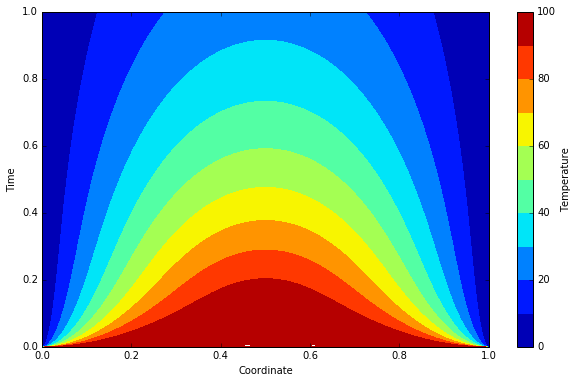

In [9]:
#Аналитически
obj = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'A')
obj.run(snapshots)

eta =  0.16


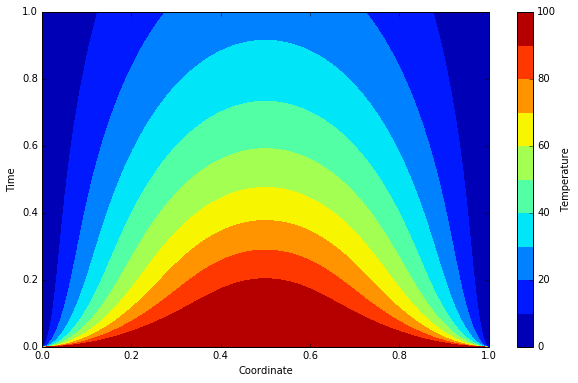

In [10]:
#Явная схема T = T0
obj2 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'E')
obj2.run(snapshots)

eta =  0.16


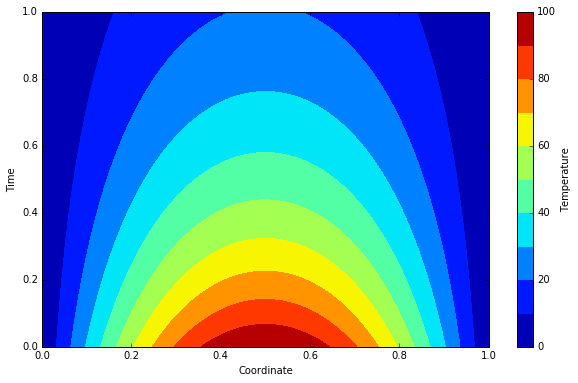

In [11]:
#Явная схема T = T0*sin(...)
T0_profile = T0*np.sin(np.pi*np.linspace(0, Lx, int(Lx/dx + 1))/Lx)
T0_profile[0] = T0_profile[-1]  = 0


obj3 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'E')
obj3.run(snapshots)

eta =  0.16


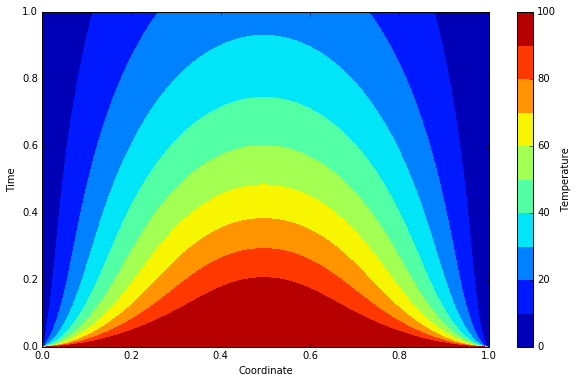

In [12]:
#Неявная схема T = T0
T0_profile = np.ones(int(Lx/dx + 1))*T0
T0_profile[0] = T0_profile[-1]  = 0

obj4 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'NE')
obj4.run(snapshots)

eta =  0.16


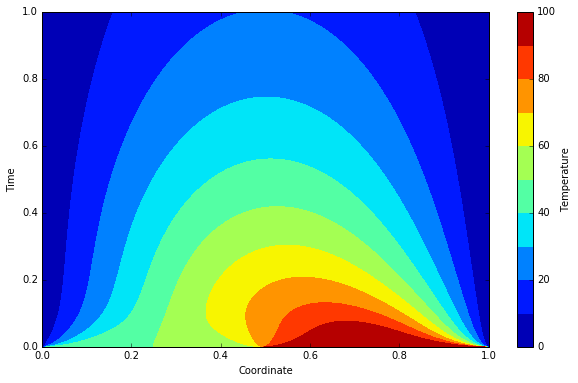

In [13]:
#Неявная схема, 2 стержня
T0_profile = np.ones(int(Lx/dx + 1))*T0
T0_profile[:int(Lx/dx + 1)/2] = T0/2
T0_profile[0] = T0_profile[-1]  = 0

obj5 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'NE')
obj5.run(snapshots)

eta =  0.16


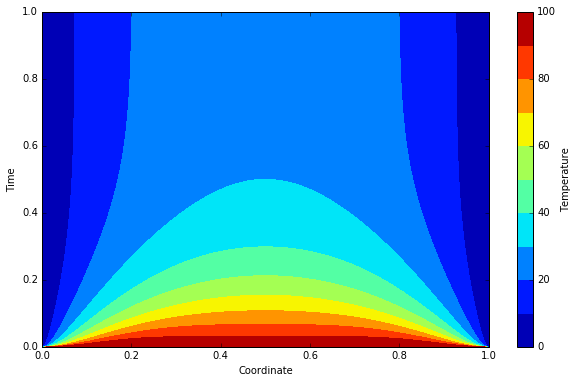

In [14]:
#Явная схема, охлаждение Ньютона. 1 стержень
T0 = 100.  
(a, Lx, Lt, dx, dt) = (0.4, 1., 1., .01, .0001) # a < 0.5!
T0_profile = np.ones(int(Lx/dx + 1))*T0
T0_profile[0] = T0_profile[-1]  = 0

obj6 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'EN')
obj6.set_T_e_and_h( 30., 5.)
obj6.run(snapshots)

eta =  0.16


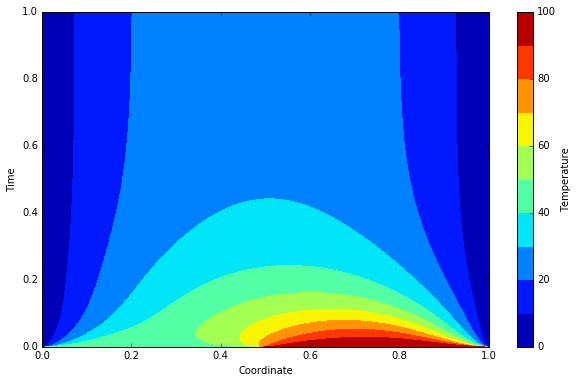

In [15]:
#Явная схема, охлаждение Ньютона. 2 стержня
T0 = 100.  
(a, Lx, Lt, dx, dt) = (0.4, 1., 1., .01, .0001) # a < 0.5!

T0_profile = np.ones(int(Lx/dx + 1))*T0
T0_profile[:int(Lx/dx + 1)/2] = T0/2
T0_profile[0] = T0_profile[-1]  = 0

obj7 = Therm_cond(a, T0, T0_profile, Lx, Lt, dx, dt, 'EN')
obj7.set_T_e_and_h( 30., 5.)
obj7.run(snapshots)